### Computational Economics
Alexander Skorobogatov

### I.
VAR(1) is given by:
$$x_{t} = a_{11} x_{t-1} + a_{12} y_{t-1} + u_t$$ 
$$y_{t} = a_{21} x_{t-1} + a_{22} y_{t-1} + v_t$$  
or in matrix form
$$x_{t} = A x_{t-1} + \epsilon_{t}$$
where $\epsilon_{t}$ ~ $N(0,\Sigma)$

1. Create a matrix A of a stable system (absolute eigenvalues of $A$ should be less than unity)  
2. Simulate a dataset in line with A (calculate the eigenvalues)  
3. Calculate the reverse polynomial
4. Visualize the system  
5. Estimate VAR model and report the results
6. Report irfs
7. Calculate irfs manually to check the way it is done by the program

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [337]:
# 1
A = np.random.uniform(-0.5,0.5,(2,2))
print(A)
np.linalg.eig(A)

[[-0.09138256 -0.17945011]
 [-0.40393215 -0.19381171]]


(array([ 0.13146235, -0.41665662]),
 array([[ 0.6271942 ,  0.48305373],
        [-0.77886291,  0.87559071]]))

In [338]:
# 1.2
a,b,c = (A[0,0]*A[1,1] - A[0,1]*A[1,0]),-(A[0,0]+A[1,1]),1
d = (-b)**2 - 4*(a*c)
r1 = (-b + np.sqrt(d))/(2*a)
r2 = (-b - np.sqrt(d))/(2*a)
print(d)
print(r1)
print(r2)

0.30043440576564967
-2.4000578605292415
7.606740708287303


### 3. Reverse characteristic polynomial a different way

In [2]:
from sympy import solve, symbols, MatrixSymbol,Eq,collect
from sympy.matrices import Matrix
from sympy import Identity

In [5]:
# Reproduce the example from Lutkepohl p. 17
I = Identity(3)
X1 = MatrixSymbol('X', 3, 3)
z = symbols('z')
a = np.array([[0.5,0,0],[0.1,0.1,0.3],[0,0.2,0.3]])
AA = Matrix(a)
X2 = Matrix(I - X1@z)
X3 = X2.subs(X1,AA)
X4 = X3.det()
solve(Eq(X4,0),z)

[-15.4858377035486, 2.00000000000000, 2.15250437021530]

In [8]:
X3

Matrix([
[1 - 0.5*z,         0,         0],
[   -0.1*z, 1 - 0.1*z,    -0.3*z],
[        0,    -0.2*z, 1 - 0.3*z]])

In [9]:
X4

0.015*z**3 + 0.17*z**2 - 0.9*z + 1

In [348]:
# Or from my example here
I = Identity(2)
X1 = MatrixSymbol('X', 2, 2)
z = symbols('z')
AA = Matrix(A)
X2 = Matrix(I - X1@z)
X3 = X2.subs(X1,AA)
X4 = X3.det()
solve(Eq(X4,0),z)

[-2.40005786052924, 7.60674070828730]

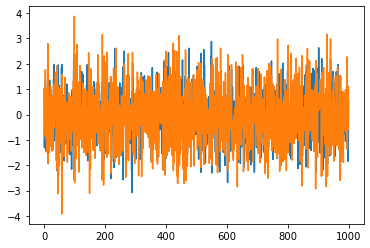

In [361]:
# 4
T = 1000
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]] 
e1,e2 = np.random.multivariate_normal(mean, cov, T).T
y = []
z = []
y.append(1)
z.append(1)
for t in range(1,T):
    a = A[0,0]*y[t-1] + A[0,1]*z[t-1] + e1[t]
    b = A[1,0]*y[t-1] + A[1,1]*z[t-1] + e2[t]
    y.append(a)
    z.append(b)
plt.plot(y, label = "line 1")
plt.plot(z, label = "line 2")

In [357]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, SVAR

In [362]:
# 5
data = np.array([y,z]).T
model = VAR(data)
res = model.fit(1)
print(res.coefs)
print(A)

[[[-0.13879687 -0.12653043]
  [-0.45520649 -0.19656712]]]
[[-0.09138256 -0.17945011]
 [-0.40393215 -0.19381171]]


In [384]:
# 6
print(res.irf(2).irfs) # program
print(f"\n Manually t+1 is \n{res.coefs@np.eye(2)}") # manually t+1
print(f"Manually t+2 is \n{np.linalg.matrix_power(res.coefs,2)@np.eye(2)}") # manually t+2

[[[ 1.          0.        ]
  [ 0.          1.        ]]

 [[-0.13879687 -0.12653043]
  [-0.45520649 -0.19656712]]

 [[ 0.07686204  0.04243375]
  [ 0.15265987  0.09623611]]]

 Manually t+1 is 
[[[-0.13879687 -0.12653043]
  [-0.45520649 -0.19656712]]]
Manually t+2 is 
[[[0.07686204 0.04243375]
  [0.15265987 0.09623611]]]


### VAR: from structural to reduced and back
1. Create structural and reduced form dataset without the error to check that the resultant series are the same
2. Compare numbers and plots
3. Create a dataset with zero error covariance
4. Compare A and coefs
5. Compare A and A_est
6. Compare B_est and the same done manually

In [385]:
# 1
A = np.random.uniform(-0.5,0.5,(2,2))
print(A)
a10 = -1.1
B = np.eye(2)
B[0,1] = -a10
print(B)
AA = np.linalg.inv(B)@A
print(AA)
T = 100
y1 = []
z1 = []
#y1.append(0)
#z1.append(0)
y1.append(1)
z1.append(1)
for t in range(1,T+1):
    b = A[1,0]*y1[t-1] + A[1,1]*z1[t-1]
    z1.append(b)
    a = A[0,0]*y1[t-1] + A[0,1]*z1[t-1] + a10*z1[t]
    y1.append(a)

y2 = []
z2 = []   
#y2.append(0)
#z2.append(0)
y2.append(1)
z2.append(1)
for t in range(1,T+1):
    a = AA[0,0]*y2[t-1] + AA[0,1]*z2[t-1]
    b = AA[1,0]*y2[t-1] + AA[1,1]*z2[t-1]
    y2.append(a)
    z2.append(b)
    
print(y1[:6])
print(z1[:6])
print(y2[:6])
print(z2[:6])

[[ 0.45787642  0.28663193]
 [ 0.40025203 -0.02511126]]
[[1.  1.1]
 [0.  1. ]]
[[ 0.01759919  0.31425432]
 [ 0.40025203 -0.02511126]]
[1, 0.3318535075261948, 0.1237299579802481, 0.04095803221790029, 0.015309870148213143, 0.005054831335475815]
[1, 0.37514076478130187, 0.12340478082932209, 0.04642431667261253, 0.015227762213744217, 0.005745418230187758]
[1, 0.3318535075261948, 0.12372995798024813, 0.04095803221790028, 0.015309870148213152, 0.005054831335475814]
[1, 0.37514076478130187, 0.12340478082932209, 0.04642431667261254, 0.015227762213744212, 0.005745418230187762]


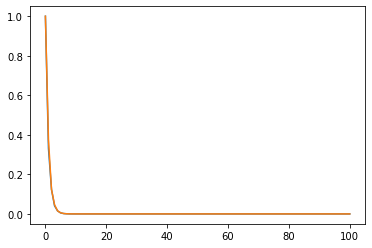

In [386]:
# 2
plt.plot(y1, label = "line 1")
plt.plot(z1, label = "line 2")

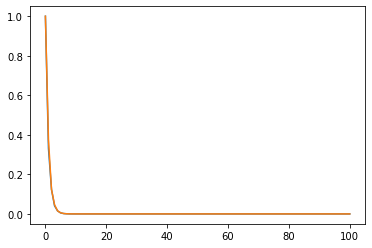

In [387]:
plt.plot(y2, label = "line 1")
plt.plot(z2, label = "line 2")

[[ 0.3860028  -0.09550924]
 [ 0.44222117 -0.01164719]]
[[1.  0.6]
 [0.  1. ]]
[[ 0.1206701  -0.08852093]
 [ 0.44222117 -0.01164719]]


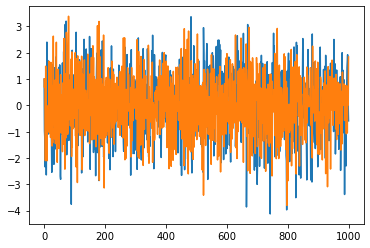

In [388]:
# 3
A = np.random.uniform(-0.5,0.5,(2,2))
print(A)
a10 = -0.6
B = np.eye(2)
B[0,1] = -a10
print(B)
AA = np.linalg.inv(B)@A
print(AA)
T = 1000
mean = [0, 0]
cov = [[1, 0], [0, 1]] 
e1,e2 = np.random.multivariate_normal(mean, cov, T).T
y1 = []
z1 = []
#y1.append(0)
#z1.append(0)
y1.append(1)
z1.append(1)
for t in range(1,T):
    b = A[1,0]*y1[t-1] + A[1,1]*z1[t-1] + e1[t]
    z1.append(b)
    a = A[0,0]*y1[t-1] + A[0,1]*z1[t-1] + a10*z1[t] + e2[t]
    y1.append(a)
plt.plot(y1, label = "line 1")
plt.plot(z1, label = "line 2")

In [392]:
# 3. SVAR Estimates

# Matrices A B
A2 = np.asarray([[1,'E'],[0,1]])
B2 = np.asarray([['E',0],[0,'E']])

# Model and results
data = np.array([y1,z1]).T
mymodel = SVAR(data, svar_type='AB', A=A2, B=B2, missing='drop')
res = mymodel.fit(maxiter=10000, maxfun=10000)

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [394]:
# 4
print(res.coefs)
print(AA)
print(A)

[[[ 0.08038859 -0.17337835]
  [ 0.42537896  0.00616689]]]
[[ 0.1206701  -0.08852093]
 [ 0.44222117 -0.01164719]]
[[ 0.3860028  -0.09550924]
 [ 0.44222117 -0.01164719]]


In [397]:
# 5
print(res.A)
print(B)

[[1.        0.6169369]
 [0.        1.       ]]
[[1.  0.6]
 [0.  1. ]]


In [411]:
# 6 ?
print(res.resid[:,0].var())
print(res.resid[:,1].var())
res.B

1.446859360794933
0.9841635018712115


array([[1.03706583, 0.        ],
       [0.        , 0.99354309]])

In [408]:
res.B

array([[1.03706583, 0.        ],
       [0.        , 0.99354309]])

### Calculate irfs from SVAR manually
1. Report irfs  
2. Calculate manually  
3. Calculate the Cholesky decomposition from the example

In [412]:
# 1.
res.irf(3).svar_irfs

array([[[ 1.03706583, -0.6129534 ],
        [ 0.        ,  0.99354309]],

       [[ 0.08336826, -0.22153332],
        [ 0.44114598, -0.25461041]],

       [[-0.06978331,  0.02633518],
        [ 0.0381836 , -0.09580577]],

       [[-0.01222999,  0.01872769],
        [-0.02944888,  0.01061161]]])

In [414]:
# 2
irf1 = np.linalg.inv(res.A)@res.B # for t
irf1

array([[ 1.03706583, -0.6129534 ],
       [ 0.        ,  0.99354309]])

In [418]:
# then use coefs
print(res.coefs@irf1) # t+1
print(np.linalg.matrix_power(res.coefs,2)@irf1) # t+2
print(np.linalg.matrix_power(res.coefs,3)@irf1) # t+3

[[[ 0.08336826 -0.22153332]
  [ 0.44114598 -0.25461041]]]
[[[-0.06978331  0.02633518]
  [ 0.0381836  -0.09580577]]]
[[[-0.01222999  0.01872769]
  [-0.02944888  0.01061161]]]


In [142]:
# Cholesky from Lutkepohl p.59
eu = np.array([[2.25,0,0],[0,1,0.5],[0,0.5,0.74]])
eu

array([[2.25, 0.  , 0.  ],
       [0.  , 1.  , 0.5 ],
       [0.  , 0.5 , 0.74]])

In [144]:
P = np.linalg.cholesky(eu)
P

array([[1.5, 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.7]])

In [145]:
a@P

array([[0.75, 0.  , 0.  ],
       [0.15, 0.25, 0.21],
       [0.  , 0.35, 0.21]])

In [146]:
a@a@P

array([[0.375, 0.   , 0.   ],
       [0.09 , 0.13 , 0.084],
       [0.03 , 0.155, 0.105]])